# Membrane potential drives the exit from pluripotency and the ontogeny of cell fate via calcium and mTOR


*Emily Sempou, Valentyna Kostiuk, Jie Zhu, Cecilia Guerra, Woong Hwang, Michael J. Caplan, David Zenisek, Aryeh Warmflash, Nick D. L. Owens, Mustafa K. Khokha*


Notebook to perform analysis and generate figures.

In [1]:
include(joinpath("..", "src", "project.jl"));

## Load and initial filter of RNA-seq time series data

Apply filter to retain only those genes whose TPM expression exceeds `0.4` for `6` consecutive timepoints in both UIC (uninjected control) and HIK (High K+);

In [2]:
meta, tpm, isotpm, isoweight, stats, filtind, ids = loaddata();

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


In [3]:
@show sum(filtind), mean(filtind);

(sum(filtind), mean(filtind)) = (13365, 0.38983199159958)


## GC Bias correction of RNA-seq

RNA-sequencing shows batch specific GC bias, build a dinucleotide propensity model using ERCC RNA standards spiked into samples to capture and correct this.

In [4]:
@time sgm = spike_gc_model(isotpm, 2, meta, pseudocount=2); ### build spike model
@time isomodel = isogc_mrna(isotpm, 2, sgm.models, meta, pseudocount=2); ## apply correction
tpmc = isomodel.tpmc; ### spike gc corrected tpm

isoc_weight = select(groupby(combine(groupby(isomodel.igc, [:Gene, :Isoform]), 
            :ModelPredict => mean => :ModelPredict), :Gene), 
            :Isoform, :ModelPredict => (x -> replace(x/sum(x), NaN => 1/length(x))) => :Weight) # calculate reweighted informs
promgene = loadpromoters(isoc_weight); ## load promoter of the maximally expressed isoform.

 22.743294 seconds (56.25 M allocations: 3.168 GiB, 3.36% gc time, 99.69% compilation time)
  1.825816 seconds (8.33 M allocations: 480.145 MiB, 5.24% gc time)
  0.171512 seconds (399.80 k allocations: 69.059 MiB, 11.98% gc time, 93.83% compilation time)
 14.411896 seconds (39.88 M allocations: 4.468 GiB, 10.50% gc time, 64.33% compilation time)


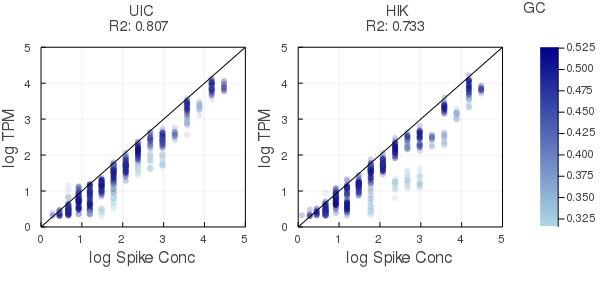

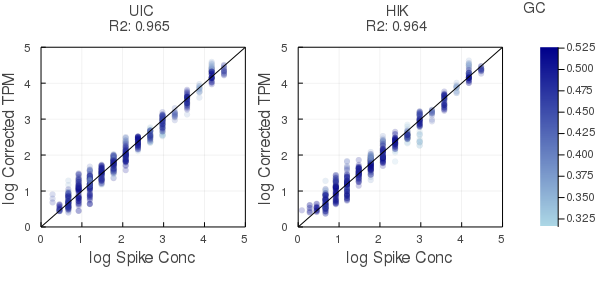

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9b_errcc_uncorrected.svg
Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9b_errcc_corrected.svg


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [5]:
plotspikemodel(sgm.models, sgm.sgc_tables, ["UIC", "HIK"], plot_model=false, bottom_margin=10mm); savedisplay("sup_fig9b_errcc_uncorrected");
plotspikemodel(sgm.models, sgm.sgc_tables, ["UIC", "HIK"], plot_model=true, bottom_margin=10mm); savedisplay("sup_fig9b_errcc_corrected");

## Data correlation and PCA plots

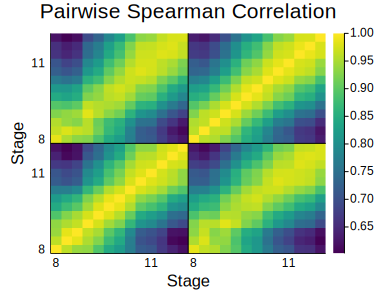

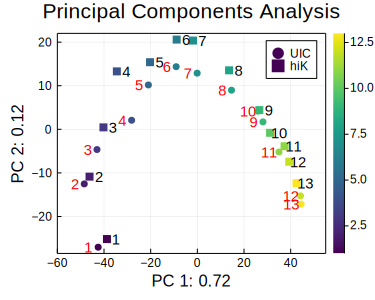

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9c_pairwise_spearman.svg
Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9d_pca.svg


In [6]:

cc = pairwisecorrelationplot(meta, tpmc[filtind, :]) #, clims=(0.3, 1))
plot!(size=(375, 300), title="Pairwise Spearman Correlation", xlabel="Stage", ylabel="Stage", fontfamily="helvetica")
savedisplay("sup_fig9c_pairwise_spearman");

p = pcaplot(meta,  tpmc[filtind, :], grid=true, framestyle=:box, title="Principal Components Analysis", fontfamily="helvetica")
plot!(fontfamily="helvetica", size=(375*1.0, 300*1.0), xlims=(-60, 55))
savedisplay("sup_fig9d_pca");

## Additional filtering prior to differential expression testing

Exclude genes with very large GC model corrections. Two additional conditions:

  1. No fold change uncorrected/corrected outside 2^(-2:4.5)
  2. No fold change HIK/UIC outside 2^(-3:3)

In [7]:
filtfc(fc, l=-2, u=4) = .!isnan.(fc) .& .!isinf.(fc) .& (l .≤ fc .≤ u)

fct_tpm  = (l=-2.5, u=4.5)
fct_pair = (l=-3, u=3)
exind_fc_tpm  = @with isomodel.modelstats_gene filtfc(:mu_fc_uic, fct_tpm...) .& filtfc(:mu_fc_hik, fct_tpm...)
exind_fc_pair = @with isomodel.modelstats_gene filtfc(:fc_H_U, fct_pair...)


spikeind = occursin.(r"^ERCC", tpmc.Gene)
miss_ind = filtind .& .!spikeind .& (.!exind_fc_tpm .| .!exind_fc_tpm);

@show sum(exind_fc_tpm), sum(filtind), sum(exind_fc_pair)
@show sum(miss_ind)

combine(groupby(DataFrame(LongestRunCondition = filtind, FC_Correction=exind_fc_tpm, FC_condition=exind_fc_pair), [:LongestRunCondition, :FC_Correction, :FC_condition], sort=true), nrow => :count)

(sum(exind_fc_tpm), sum(filtind), sum(exind_fc_pair)) = (22632, 13365, 22970)
sum(miss_ind) = 162


,LongestRunCondition,FC_Correction,FC_condition,count
,Bool,Bool,Bool,Int64
1,0,0,0,11178
2,0,0,1,309
3,0,1,0,130
4,0,1,1,9302
5,1,0,0,6
6,1,0,1,159
7,1,1,1,13200


In [8]:
exfiltind = filtind .& exind_fc_tpm .& exind_fc_pair .& .!spikeind;
println("Final selected: ", sum(exfiltind), " genes")

Final selected: 13148 genes


In [9]:
tpmc[!, :filtind] = filtind;
f_ind = findall(exfiltind);
fgenes = tpmc.Gene[f_ind];


# Temporal Differentiatial Expression using Gaussian Process Regression

In [10]:
GPC = @showprogress [gp_set_dt(i, meta, tpmc) for i ∈ f_ind];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49m


In [11]:
metagp, tpmc_gp, gpc_pt = gptable(fgenes, GPC);

### Differential expression statistics, LR = log-likelihood ratio, genes with LR > 0 are considered differentially expressed

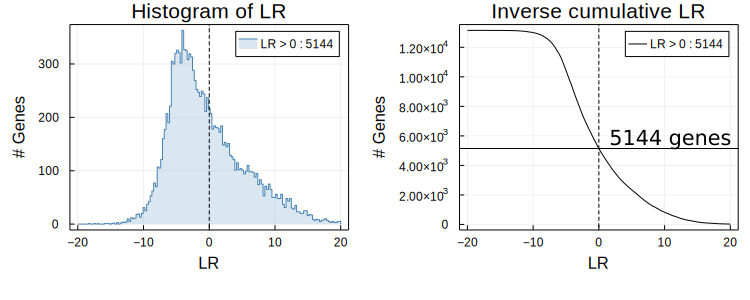

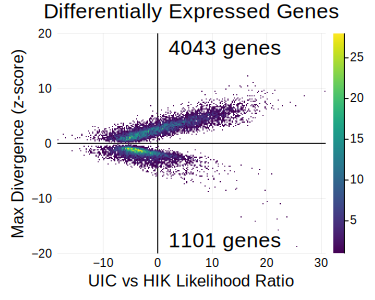

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\lr_histogram.svg
Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9e_lr_divergence.svg


In [12]:
lrhistogram(gpc_pt); savedisplay("lr_histogram")
lr_cd_hist(gpc_pt); savedisplay("sup_fig9e_lr_divergence")

## Clustering of differentially expressed genes

k-means clustering of activated and repressed differentially expressed genes separately. Use cluster silhouettes to determine suitable choice of k.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


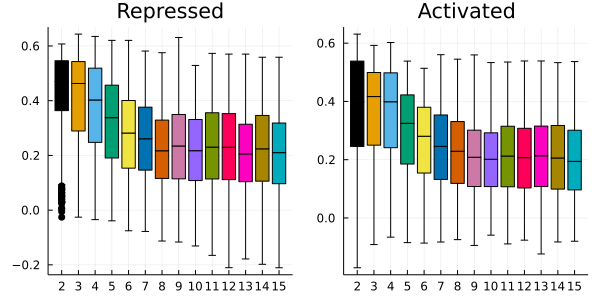

In [13]:
cl_ind = (gpc_pt.LR .> 0)
cluster_silhouettes_ud(metagp, tpmc_gp, cl_ind, 2:15, seed=16)

Select `k = 4` in case case as a choice that captures behaviours prior to drop in median silhouette score.

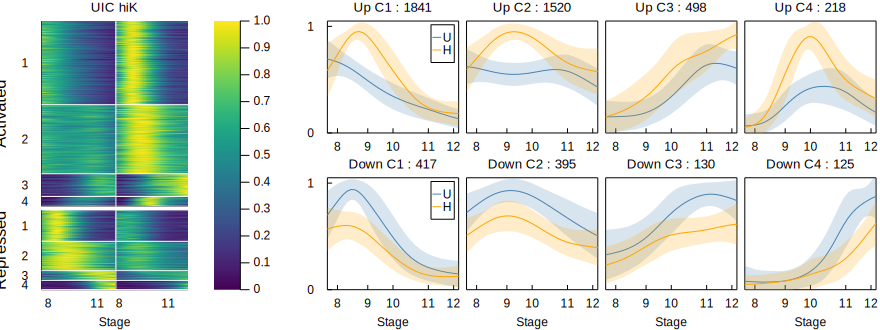

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9fg_cluster_overview.svg


GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [14]:
KMK_UD = pot_kmeans_ud(metagp, tpmc_gp, cl_ind, 4, 4, seed=16);
plotclusterud_stack(KMK_UD)
savedisplay("sup_fig9fg_cluster_overview")

## Cluster promoter motif enrichment

Write bed file defining intervals [-500bp, TSS] for the maximally expressed isoform of each gene. This bed file will be used with Homer to determine enriched vertebrate transcription factor motifs.

Bash script for running homer over 4 activated and 4 repressed clusters:


```bash
mbed=pot_xen_hik_cluster_promoters.500.bed
genome=XT9_1.fa
background=XENTR_9.1_Xenbase_spike.unique.tss.500.fa
for cl in 1 2 3 4
do
    for d in U D
    do
        sam=${outdir}/${mbed/.bed/.${d}${cl}}
        grep ${d}[${cl}] ${mbed} > ${sam}.bed
        bedtools getfasta -fi ${genome} -bed ${sam}.bed > ${sam}.fa
        findMotifs.pl ${sam}.fa fasta homermotif_${d}_${cl}_bgT -fasta $background -p 12 -nomotif -mset vertebrates
    done
done
   
```


In [15]:
promclusters = leftjoin(KMK_UD.gtable, promgene, on=:Gene) 
promclusters.CLabel = clabel.(promclusters.ClusterD, promclusters.ClusterU);
promclusters.loc = @with promclusters string.(:chrom, ":", :PromoterStart, "-", :PromoterStop);
prombed = @subset(promclusters[!, [:chrom, :PromoterStart, :PromoterStop, :CLabel, :strand, :Length, :Gene, :GeneName, :ClusterU, :ClusterD]], :Length .== 500);
savepromoterclusterbed(promclusters);

#### Load resulting Homer known vertebrate motif enrichments

In [16]:
hommots = loadhomerres("..\\results\\homer_vertebrate_500\\");

# Gene Set enrichments of differentially expressed genes using Enrichr

Calculate gene set enrichments for activated and repressed clusters using Enrichr API:

In [17]:
@time en_ud = enrichr_ud(KMK_UD);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:06
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


209.334740 seconds (18.66 M allocations: 813.325 MiB, 0.04% gc time, 0.79% compilation time)


### Save enrichr results

In [18]:
enc = @subset(en_ud, .!occursin.(",", :CLC))
enc.Genes = join.(enc.Genes, ", ")
rename!(enc, :GeneSet => :GeneSetLibrary, :CLC => :Cluster)
enc = enc[!, [:Direction, :Cluster, :GeneSetLibrary, :Rank, :Term, :pvalue, :zscore, :Combined, :padj, :NumGenes, :Genes]]
enc.Direction = getindex.(Ref(Dict("Up" => "Activated", "Down" => "Repressed")), enc.Direction)
mkpath(joinpath("..", "results"))
CSV.write(joinpath("..", "results", "pot_degenes_enrichr_genesets.tsv.gz"), enc, delim='\t', compress=true);

# Figure 3 - principal genomics figure


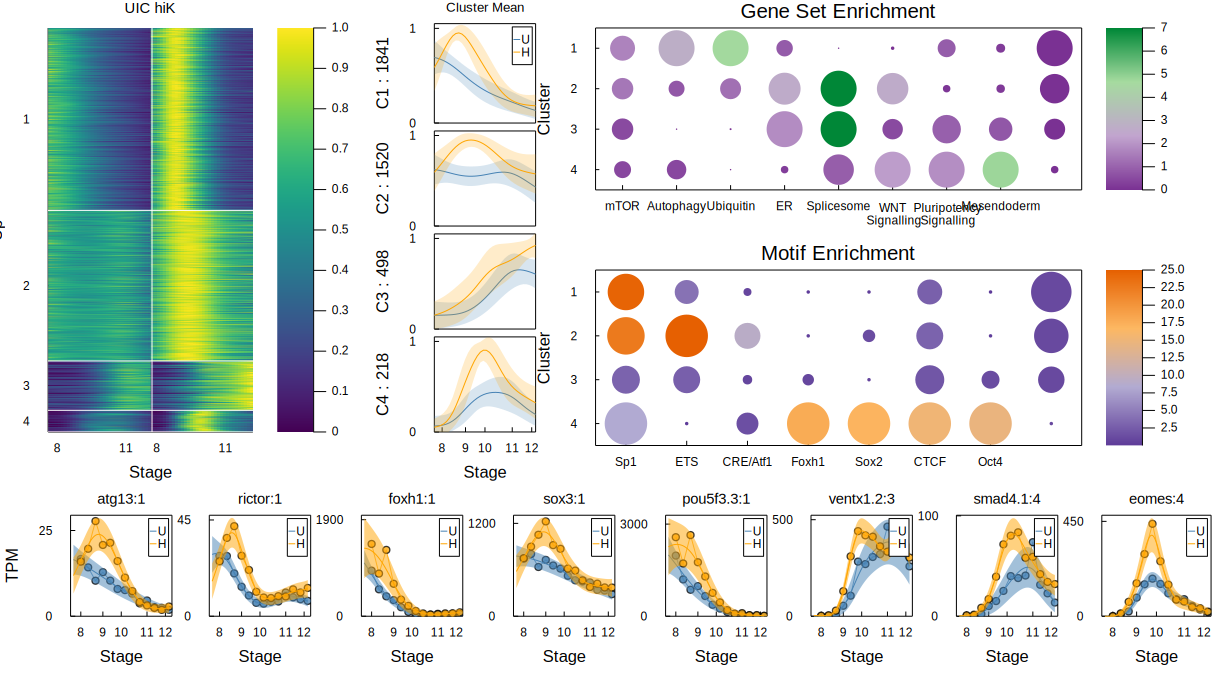

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\fig3.svg


In [19]:
plot_cluster_enrich_vert(KMK_UD, en_ud, enrichr_term_selection(), hommots.sigtable[hommots.sigtable.Sel, :], size=(900*1.35,500*1.35), fontfamily="helvetica")
savedisplay("fig3")

#### Sequence logos for selected motifs

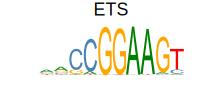

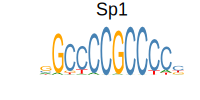

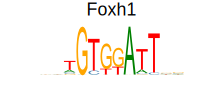

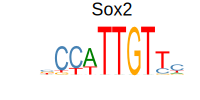

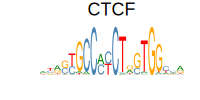

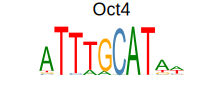

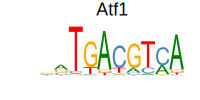

In [20]:
seqlogo_selection(hommots)

## Supplemental panels for motif enrichment and calcium response

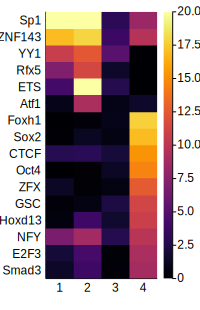

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9h.svg


In [21]:
motif_supplemental(hommots, ind=1:16)
savedisplay("sup_fig9h")

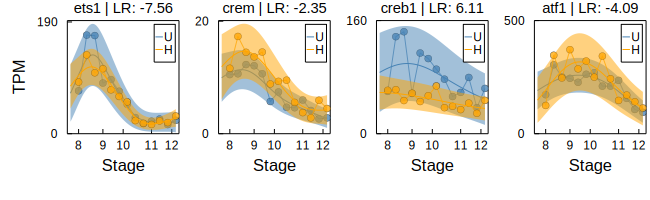

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9i_calcium_responsive_tfs.svg


In [22]:
fgs = ["ets1" , "crem", "creb1", "atf1"]
plot_gp_selection(fgs, fgenes, GPC)
savedisplay("sup_fig9i_calcium_responsive_tfs")

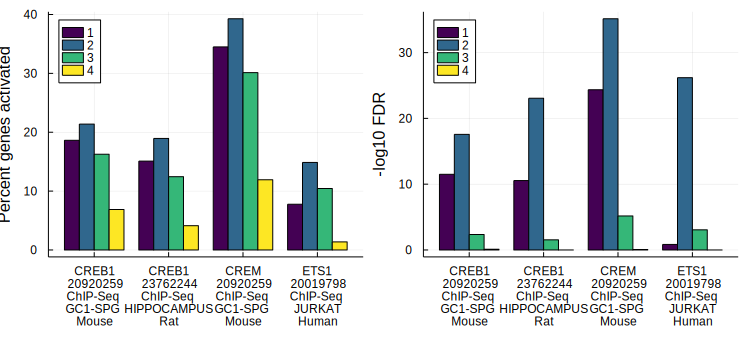

Writing C:\home\projects\pot\paper\KCNH6GenomicsFigures\figures\sup_fig9j_calcium_responsive_tfs_enrichments.svg


In [23]:
calcium_responsive_tf_enrichment(KMK_UD, en_ud)
savedisplay("sup_fig9j_calcium_responsive_tfs_enrichments")